# 文本和字节序列
*人类使用文本，计算机使用字节序列*

## 字符(Unicode)

- 字符的标识（码位）: U+20AC (4～6个十六进制数)
- 字符的字节表述 : 取决于所用编码(编码是码位与字节序列进行相互转换的算法)


编码：将码位转换成字节序列；解码：将字节序列转换成码位

In [ ]:
s = '中文'
print(len(s))
b = s.encode('utf8')
print(b)
print(len(b))
print(b.decode('utf8'))

bytes或bytearray对象的各个元素是介于0～255之间的整数。

In [ ]:
b = bytes('中文', encoding='utf_8')
print(b)
print(b[0])
print(b[:1])
b_arr = bytearray(b)
print(b_arr)
print(b_arr[-1:])

二进制序列的切片始终是同一类型的二进制序列，即使切片长度仅为1。

```s[0] == s[:1]```只对str这个序列类型成立，对其他所有序列类型都不成立。

In [ ]:
s = '中文'
print(s[0] == s[:1])
b = bytes(s, 'utf8')
print(b[0] == b[:1])

二进制序列(整数序列)的字面量表示法:
- 可打印的ASCII范围内字节（从空格到～），使用ASCII字符
- 制表符，换行符，回车符和\对应的字节，使用转义序列\t,\n,\r和\\
- 其他字节的值，使用十六进制转义序列（ex. \x00表示空字节）

利用缓冲类对象构建二进制序列是一种底层操作，可能涉及类型转换

In [ ]:
import array
arr = array.array('h', [-2, -1, 0, 1, 2]) #h indicates short integer
b = bytes(arr)
print(b)

## 基本的编解码器
Python自带了超过100种编解码器（codec，decoder/encoder），用于文本和字节的相互转换。

每个编解码器都有个名称，如utf_8，而且通常有几个别名，如utf-8,utf8,U8。可以传给open(),str.encode(),bytes.decode()。

## 编码问题
- 不正确的编码方式：UnicodeEncodeError
- 不匹配的解码方式：UnicodeDecodeError
- 预期之外的编码加载模块：SyntaxError 编码源码时，python3 default utf8, python2 default ASCII(这时需要在文件顶部显式的添加coding注释)

In [ ]:
s = '中文'
try:
    s.encode('latin1') #default is 'strict', throw UnicodeEncodeError when encode failed
except UnicodeEncodeError:
    print('UnicodeEncodeError')
print(s.encode('latin1', errors = 'ignore'))
print(s.encode('latin1', errors = 'replace'))
print(s.encode('latin1', errors = 'xmlcharrefreplace'))

### 如何找出字节序列的编码
除非有人告诉你，否则只能通过试探和分析来推测文件编码

统一字符编码侦测包Chardet能识别支持的30种编码，Chardet是一个python库，但也提供了命令行工具chardetect

### 字节序标记BOM（Byte Order Mark）
UTF格式可以在文本开头添加不可见的字符U+FEFF来表明字节顺序，不带BOM的话UTF16默认用大字节序
- 小字节序UTF16-LE 低位在前b'\xFF\xFE'，Intel x86采用小字节序
- 大字节序UTF16-BE 高位在前b'\xFE\xFF'

字节序只与多字节编码有关系，单字节编码的UTF8生成的字节序始终保持一致，因此不用BOM(Windows应用有时会添加b'\xEF\xBB\BF'来判定UTF8编码)

## 处理文本文件
Unicode三明治： 尽早将输入的字节序列解码成字符串；随后的处理过程中，一定不能编码或解码；尽量晚地将字符串编码成字节序列输出
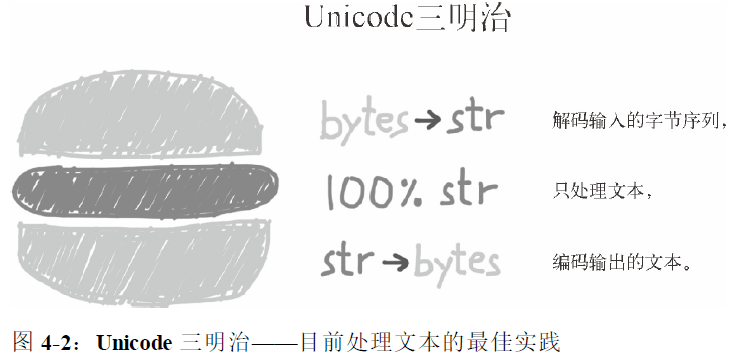
多数的Web框架采用了这样的处理，Python3中内置的open函数读取文件时会做必要的解码，以文本模式写入文件时还会做必要的编码

默认编码：
- 如果打开文件时没指定encoding参数，默认值由locale.getpreferredencoding()提供
- 如果设定了PYTHONIOENCODING环境变量，sys.stdout/stdin/stderr的编码用设定的值，否则继承自所在控制台；若重定向到文件，则由locale.getpreferredencoding()定义
- Python2在二进制数据与字符串之间转换时，内部使用sys.getdefaultencoding()获得的编码；Python3很少这么做
- sys.getfilesystemencoding()用于编解码文件名（而非文件内容）。open()函数处理字符串的文件名时这样使用

locale.getpreferredencoding()返回用户偏好设置的编码，但是这个编码是不能绝对相信的。（返回的只是猜测的编码）

所以，关于编码默认值的最佳建议是：**别依赖默认值**

## 为了正确比较而规范化Unicode字符串
在Unicode标准中，é和e\u0301这样的序列叫“标准等价物”(canonical equivalent)。应用程序应当视为相等。

但由于Python看到的是不同码位序列，因此判定二者不等。

解决方案是使用unicodedata.normalize函数提供的Unicode规范化。第一个参数是['NFC','NFD','NFKC','NFKD']中的一个

NFD将字符分解成基字符和组合记号

In [ ]:
from unicodedata import normalize
s1 = 'café' # e和重音符组合在一起
s2 = 'cafe\u0301' # 分解成e和重音符
print(len(s1), len(s2))
print(s1 == s2)
print(len(normalize('NFC', s1)), len(normalize('NFC', s2)))

NFC是最好的规范化形式，不区分大小写的比较应该用str.casefold()做大小写折叠。

若要处理多语言文本，参考normeq.py里的nfc_equal和fold_equal函数

### Unicode排序算法对Unicode文本进行排序
PyUCA库，使用Unicode排序算法（Unicode Collation Algorithm, UCA）的纯Python实现